# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_i, y_train = train['features'], train['labels']
X_test_i, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np
# TODO: Number of training examples
n_train_i = len(X_train_i)

# TODO: Number of testing examples.
n_test = len(X_test_i)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train_i[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = max(y_train)+1
class_num = np.bincount(y_train)

print("Number of training examples from dataset =", n_train_i)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes, max(class_num), min(class_num))

Number of training examples from dataset = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43 2250 210


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
import cv2
import numpy as np
#from skimage import exposure

def img_histeq_adp(img):
    # convert to lab color model
    l_img= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    # split to different channels
    l, a, b = cv2.split(l_img)
    
    # apply CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    cl = clahe.apply(l)
    # Merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))
    # convert back to rgb image
    fimage = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    return fimage

In [4]:
import cv2
import numpy as np
#from skimage import exposure
#from skimage import color

# change image to gray scale and perform adaptive histogram equalization
def gray_histeq(img):
    # change image to gray scale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # apply adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4,4))
    res_img = clahe.apply(img_gray)
    
    return res_img

In [5]:
from skimage import transform as tf
from skimage import img_as_ubyte

def shear_image(img, sa = 0.2):
    # create transform
    afine_tf = tf.AffineTransform(shear = sa)
    # apply affine transform to input image
    simage = img_as_ubyte(tf.warp(img, afine_tf))
    #simage.reshape((list(simage.shape).append(1)))
    
    return simage
    

In [6]:
def img_rotate(img, angle):
    # get transform matrix
    r, c, d = img.shape
    rotationMatrix = cv2.getRotationMatrix2D((c/2, r/2), angle, 1)
    rimg = cv2.warpAffine(img, rotationMatrix, (c, r))
    rimg = np.reshape(rimg, (32, 32, 1))
    
    return rimg

In [7]:
import csv

SignNames = []
with open('signnames.csv') as csvfile:
    csv_reader = csv.DictReader(csvfile)
    for row in csv_reader:
        SignNames.append(row['SignName'])

In [8]:
def plot_dataset_dist(labels):
    v, c = np.unique(labels, return_counts=True)
    plt.figure(figsize=(15, 5))
    plt.bar(v, c)
    plt.ylabel('Frequency')
    plt.xticks(np.arange(0.0, 43.0, 1.0), SignNames, ha = 'right', rotation = 45)
    plt.title('Dataset Distribution')

25 28927


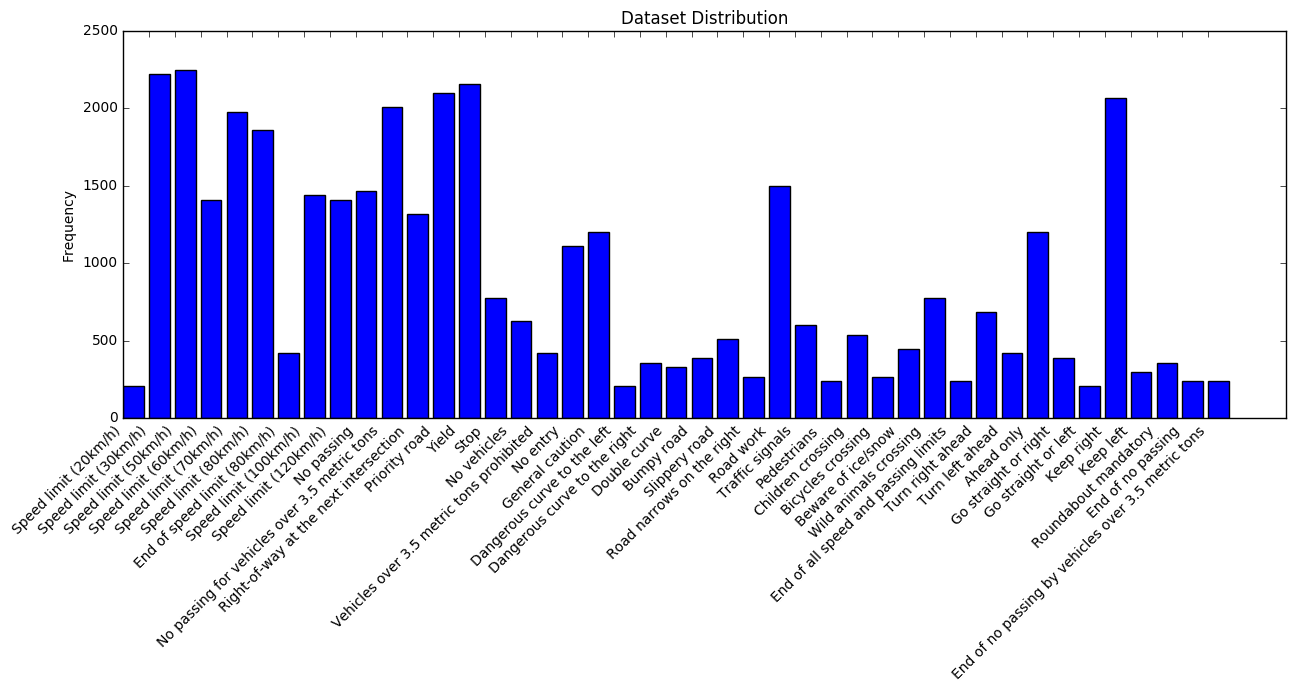

In [9]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
from skimage import transform as tf
# Visualizations will be shown in the notebook.
%matplotlib inline

index = 28927 #random.randint(0, len(X_train_i))
image = X_train_i[index].squeeze()
print(y_train[index], index)

plot_dataset_dist(y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [10]:
# grayscale images and perform histogram equalization
def xform_images(imgs):
    num = len(imgs)
    x_imgs = np.empty([num, imgs[0].shape[0], imgs[0].shape[1], 1], dtype=imgs.dtype)
    for i in range(0, num):
        x_imgs[i, :, :, 0] = gray_histeq(imgs[i])
    
    return x_imgs

Dataset after data argumentation
Number of train examples =  76103
Number of validation examples =  19026 1847 1471


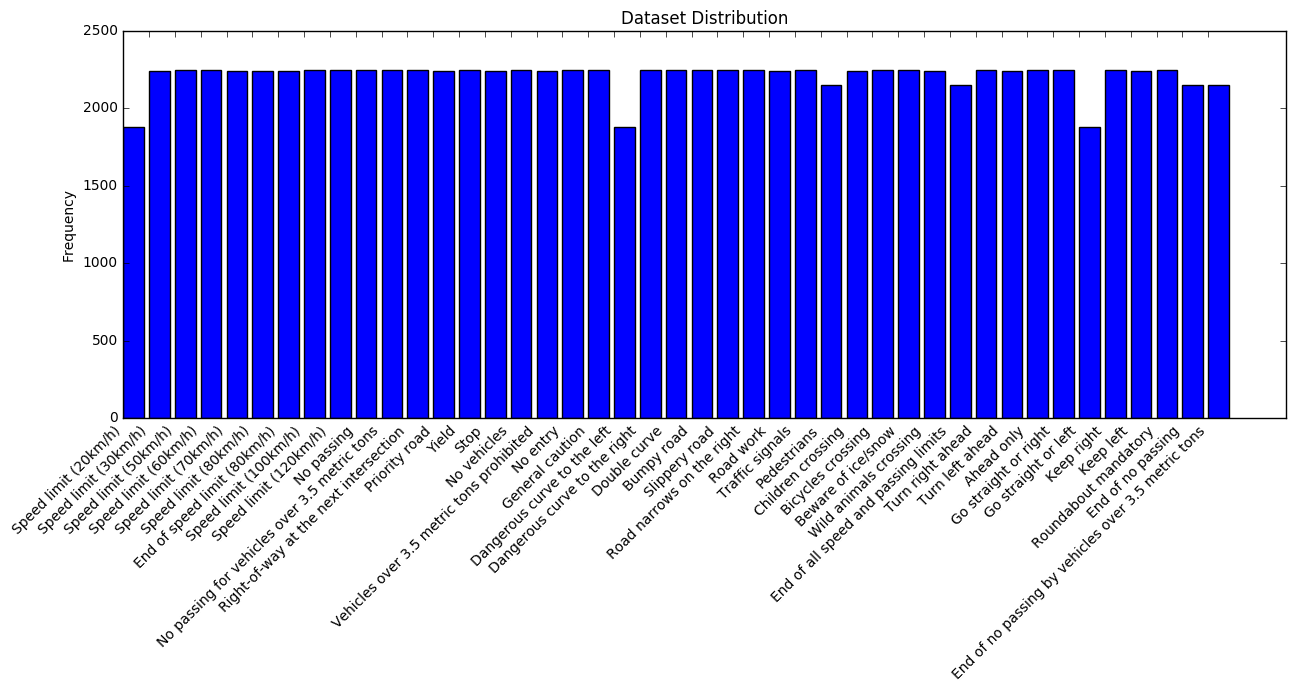

In [11]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import warnings

warnings.filterwarnings('ignore')

# change images to grayscale and apply adaptive histogram equalization
X_train = xform_images(X_train_i)
X_test  = xform_images(X_test_i)

# add images for those classes with less feature sets
for i in range(len(class_num)):
    newset = min(int((class_num.max() - class_num[i])/8), class_num[i]-1)
    if newset <= 0:
        continue
       
    new_images = []
    new_labels = []
    m = np.where(y_train == i)

    for j in range(newset):
        #k = random.randint(0, len(newset)-1)
        img = X_train[m[0][j]]
        # create 5 rotation images with angle(-90,90)
        for k in range(5):
            rtangle = random.randint(-15, 15)
            new_images.append(img_rotate(img, rtangle))
            new_labels.append(i)
        # shear image
        new_images.append(shear_image(img))
        new_labels.append(i)

        new_images.append(shear_image(img, -0.2))
        new_labels.append(i)
        # stretch the image
        nimg = cv2.resize(img,None,fx=1.5, fy=1.5, interpolation = cv2.INTER_CUBIC)
        nimg = nimg[10:42, 10:42]
        new_images.append(np.reshape(nimg, (32, 32, 1)))
        new_labels.append(i)

    X_train = np.append(X_train, new_images, axis=0)
    y_train = np.append(y_train, new_labels, axis=0)

print("Dataset after data argumentation")
plot_dataset_dist(y_train)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

train_num = np.bincount(y_train)

print("Number of train examples = ", len(X_train))
print("Number of validation examples = ", len(X_validation), max(train_num), min(train_num))

X_train, y_train = shuffle(X_train, y_train)

In [12]:
import tensorflow as tf

EPOCHS = 100
BATCH_SIZE = 64

In [13]:
from tensorflow.contrib.layers import flatten

with tf.variable_scope("cvnetw", reuse = None):
        cvw1 = tf.get_variable("cvw1", shape=[3, 3, 1, 128], initializer=tf.contrib.layers.xavier_initializer())
        cvw2 = tf.get_variable("cvw2", shape=[5, 5, 128, 256], initializer=tf.contrib.layers.xavier_initializer())
        fcw1 = tf.get_variable("fcw2", shape=[16384, 240], initializer=tf.contrib.layers.xavier_initializer())
        outw = tf.get_variable("outw", shape=[240, 43], initializer=tf.contrib.layers.xavier_initializer())

        cvb1 = tf.get_variable("cvb1", shape=[128], initializer=tf.contrib.layers.xavier_initializer())
        cvb2 = tf.get_variable("cvb2", shape=[256], initializer=tf.contrib.layers.xavier_initializer())
        fcb1 = tf.get_variable("fcb1", shape=[240], initializer=tf.contrib.layers.xavier_initializer())
        outb = tf.get_variable("outb", shape=[43], initializer=tf.contrib.layers.xavier_initializer())
       
weights = {
    'cw1': cvw1,
    'cw2': cvw2,
    'fw1': fcw1,
    'outw': outw
}

biases = {
    'cb1': cvb1,
    'cb2': cvb2,
    'fb1': fcb1,
    'outb': outb
}

def ConvNet1(x):      
    # Convolutional layer 1. Input = 32x32x3. Output = 32x32x36.
    conv1   = tf.nn.conv2d(x, weights['cw1'], strides=[1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.bias_add(conv1, biases['cb1'])

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 16x16x36.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Convolutional layer 2 Output = 16x16x64.
    conv2   = tf.nn.conv2d(conv1, weights['cw2'], strides=[1, 1, 1, 1], padding='SAME')
    conv2 = tf.nn.bias_add(conv2, biases['cb2'])
   
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 16x16x64. Output = 8x8x64.
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 6x6x64. Output = 4096
    fc0   = flatten(conv2)
    fc0   = tf.nn.tanh(fc0)

    # Full Connected: Input 4096, output 120
    fc1   = tf.matmul(fc0, weights['fw1']) + biases['fb1']

    # Output layer: Input 120, output 43
    logits = tf.matmul(fc1, weights['outw']) + biases['outb']
   
    return logits

In [14]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [15]:
rate = 0.0003

logits = ConvNet1(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './convnet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.862

EPOCH 2 ...
Validation Accuracy = 0.955

EPOCH 3 ...
Validation Accuracy = 0.980

EPOCH 4 ...
Validation Accuracy = 0.980

EPOCH 5 ...
Validation Accuracy = 0.981

EPOCH 6 ...
Validation Accuracy = 0.982

EPOCH 7 ...
Validation Accuracy = 0.985

EPOCH 8 ...
Validation Accuracy = 0.987

EPOCH 9 ...
Validation Accuracy = 0.962

EPOCH 10 ...
Validation Accuracy = 0.985

EPOCH 11 ...
Validation Accuracy = 0.982

EPOCH 12 ...
Validation Accuracy = 0.985

EPOCH 13 ...
Validation Accuracy = 0.988

EPOCH 14 ...
Validation Accuracy = 0.987

EPOCH 15 ...
Validation Accuracy = 0.991

EPOCH 16 ...
Validation Accuracy = 0.991

EPOCH 17 ...
Validation Accuracy = 0.993

EPOCH 18 ...
Validation Accuracy = 0.985

EPOCH 19 ...
Validation Accuracy = 0.991

EPOCH 20 ...
Validation Accuracy = 0.988

EPOCH 21 ...
Validation Accuracy = 0.989

EPOCH 22 ...
Validation Accuracy = 0.985

EPOCH 23 ...
Validation Accuracy = 0.979

EPOCH 24 ...
Validation Accura

In [18]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.942


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [19]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [20]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [21]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

correct labels:  [33, 23, 14, 13, 17, 25, 23]


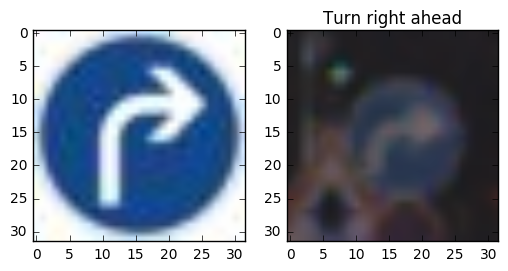

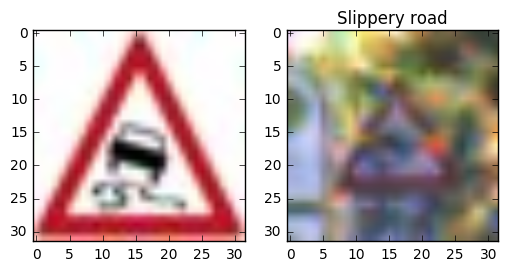

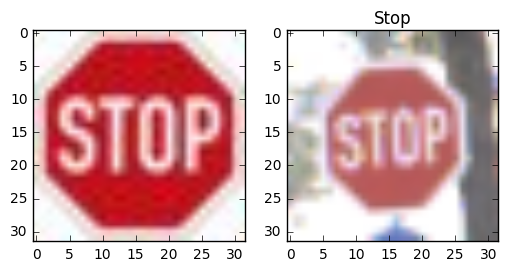

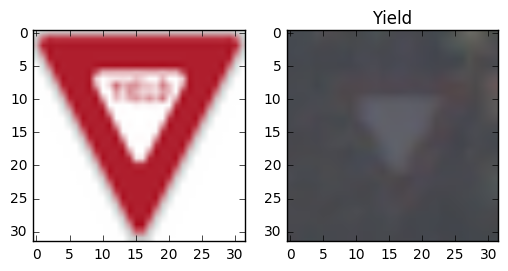

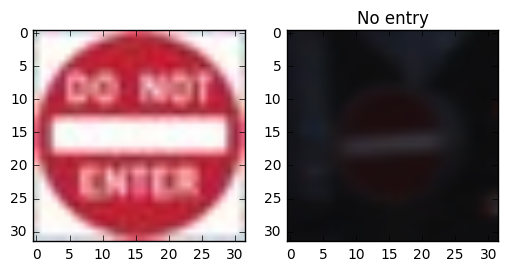

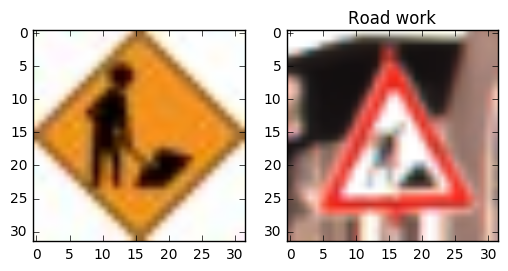

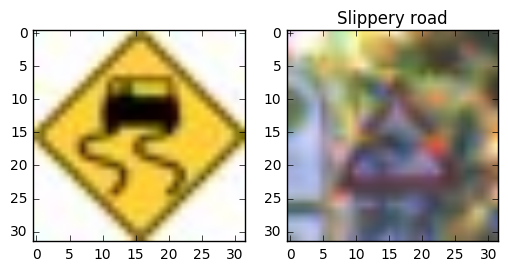

In [22]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

imgfiles = ["turnright.png", "slippery.png", "stop.png", "yield.png", "us_noentry.png", "us_roadwork.png", "us_slippery.png"]
correctlabels = [33, 23, 14, 13, 17, 25, 23]
#imgfiles = ["turnright.png"]
testimgs = []

label_i = train['labels']
i = 0
for imgname in imgfiles:
    img = img_as_ubyte(mpimg.imread('images/'+imgname))
    # show image
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(img)
    #plt.show()
    # display image from training set
    m = np.where(label_i == correctlabels[i])
    f = fig.add_subplot(1,2,2)
    f.set_title(SignNames[correctlabels[i]])
    plt.imshow(X_train_i[m[0][0]])
    i = i +1
    
    img = np.reshape(gray_histeq(img), (32, 32, 1))
    #img = img_histeq_adp(img)
    testimgs.append(img)

print("correct labels: ", correctlabels)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [23]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
import numpy as np
import tensorflow as tf

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred = sess.run(tf.nn.softmax(logits), feed_dict={x: testimgs})
    pred_labels = []
    for i in range(len(imgfiles)):
        pred_labels.append(np.argmax(pred[i]))

print("predicted labels: ", pred_labels)

predicted labels:  [33, 23, 14, 13, 17, 36, 12]


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

[33 35 36 39 40]
[  1.00000000e+00   8.83141643e-20   5.48748003e-22   3.43219401e-23
   1.50787280e-26]
[23 30 31 21 20]
[  1.00000000e+00   4.29524478e-14   3.69370189e-15   1.16290783e-17
   2.09806734e-22]
[14  6  5  4  3]
[  1.00000000e+00   1.38930940e-17   4.82040601e-20   1.43727430e-20
   2.69049158e-21]
[13 34 35 36 11]
[  1.00000000e+00   1.24480089e-14   1.06441785e-14   5.47348654e-17
   6.30729932e-18]
[17  9  8 15 40]
[  9.99581516e-01   4.17342351e-04   1.22035806e-06   9.21834332e-13
   2.38071146e-13]
[36 35 13  9 32]
[  9.39537525e-01   5.03329784e-02   9.92234796e-03   2.06131779e-04
   6.18972308e-07]
[12 14 37 36 40]
[  9.49096680e-01   5.06899580e-02   1.56246053e-04   5.48854041e-05
   1.42166380e-06]


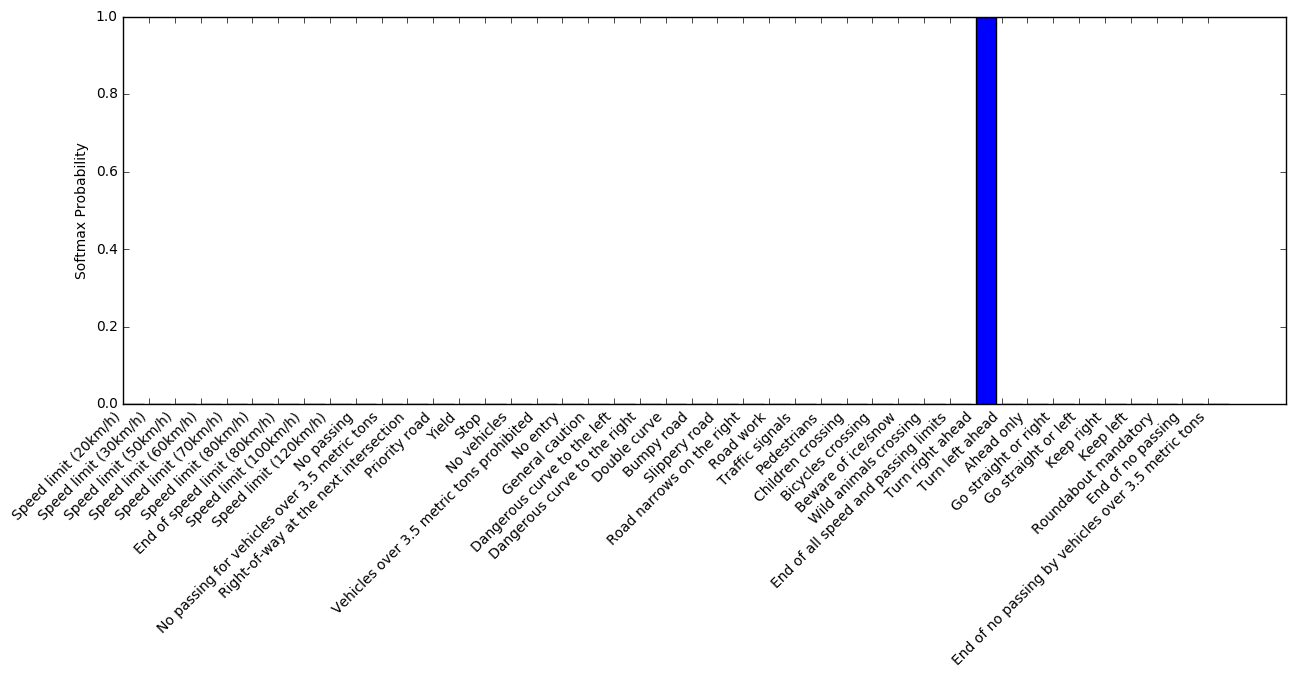

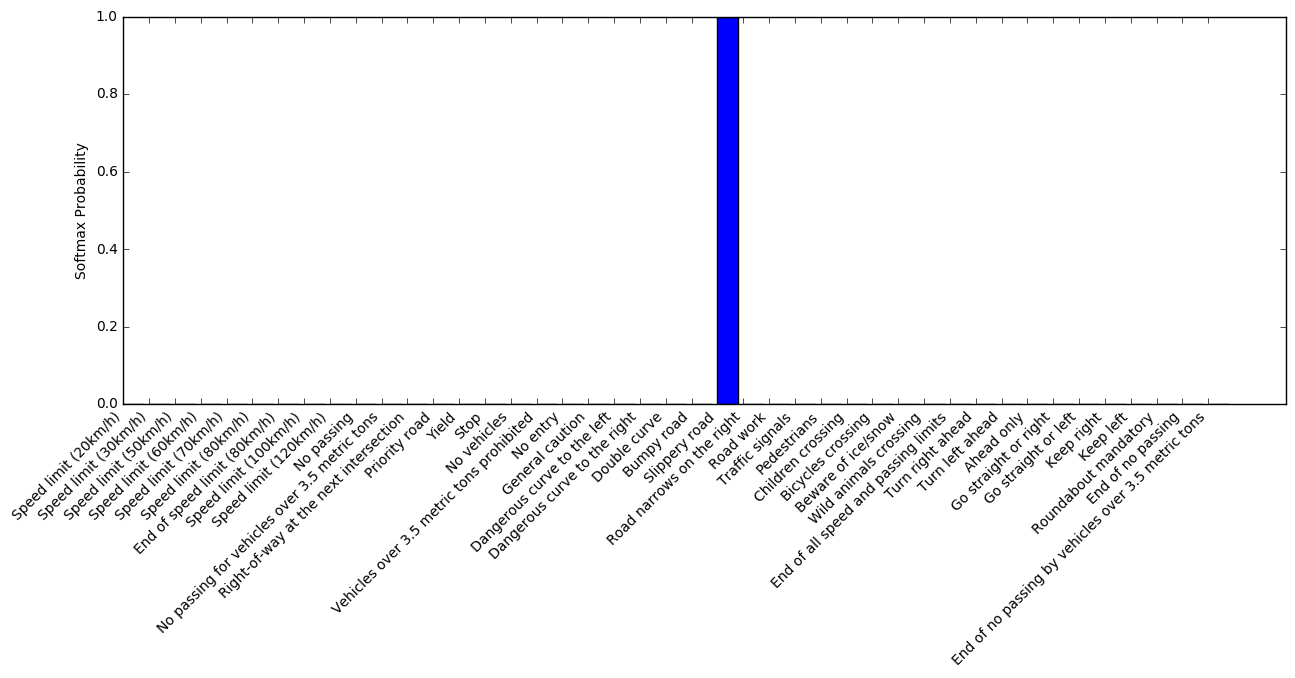

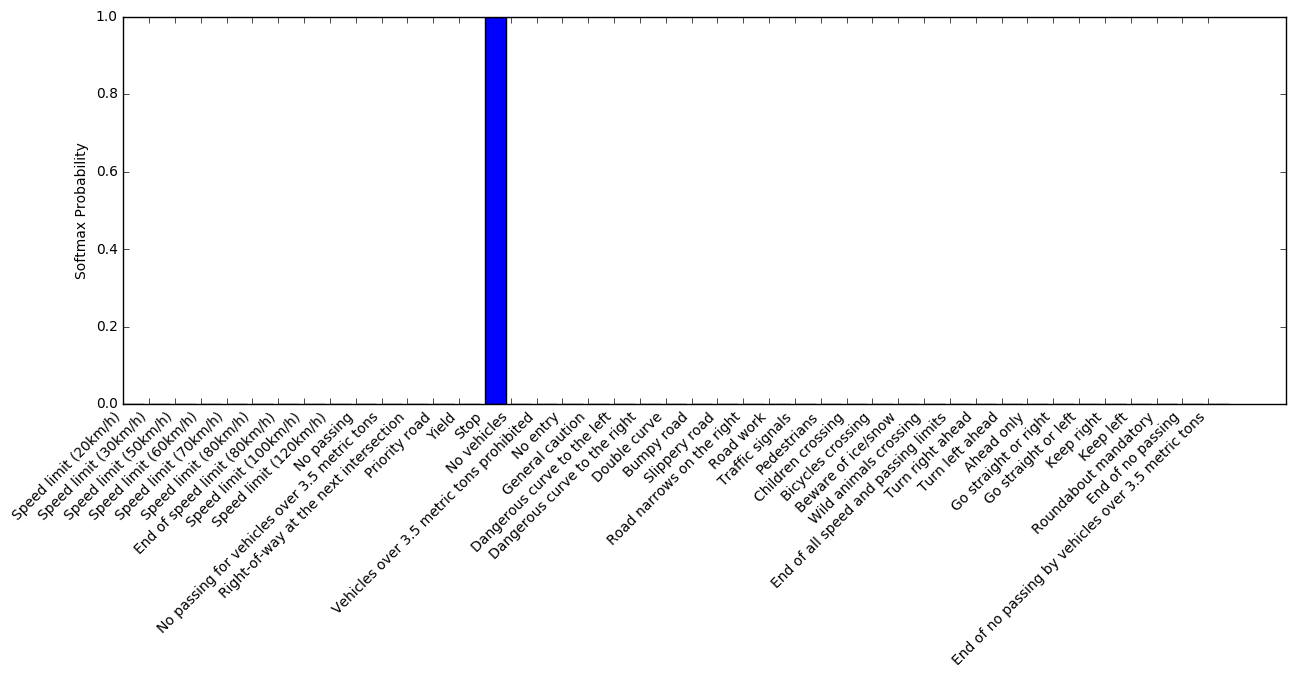

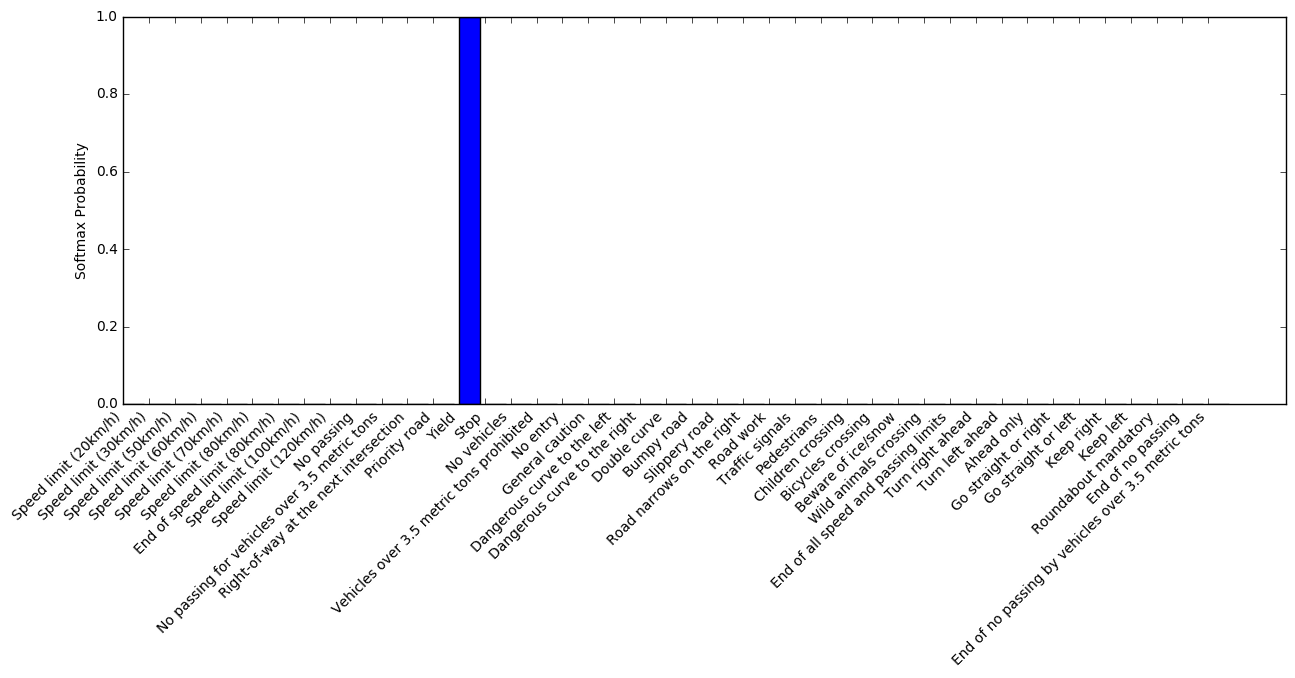

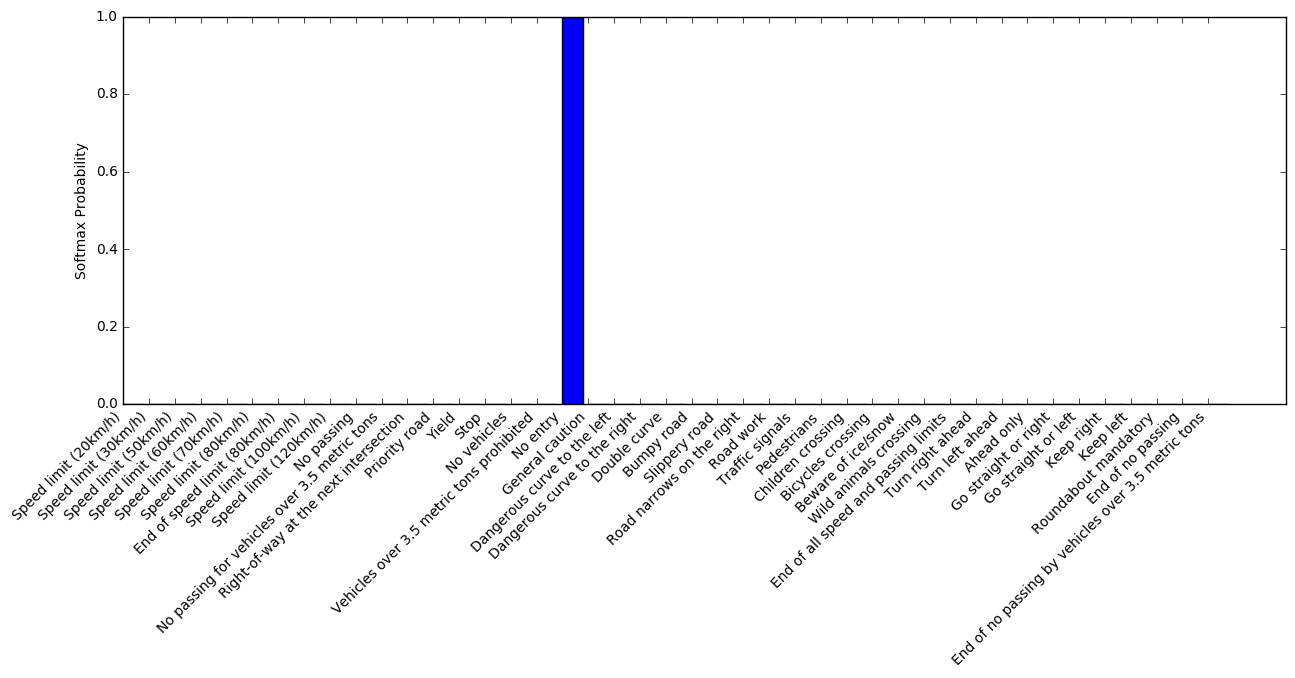

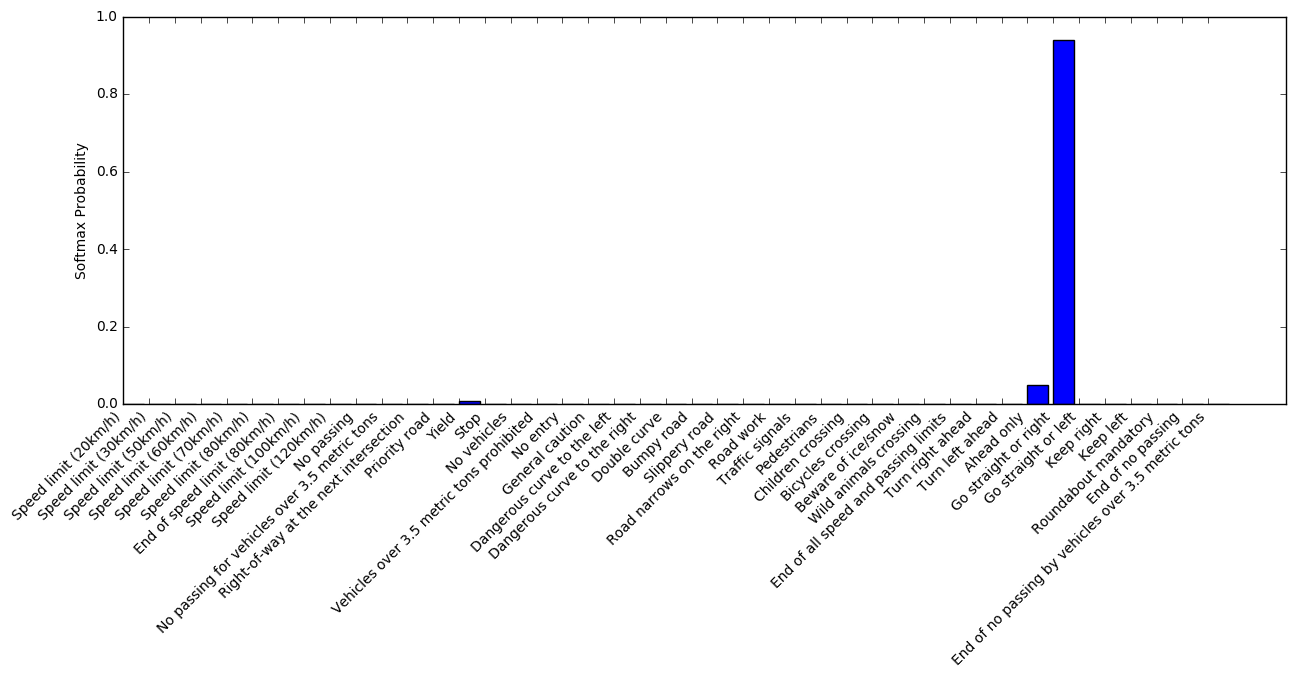

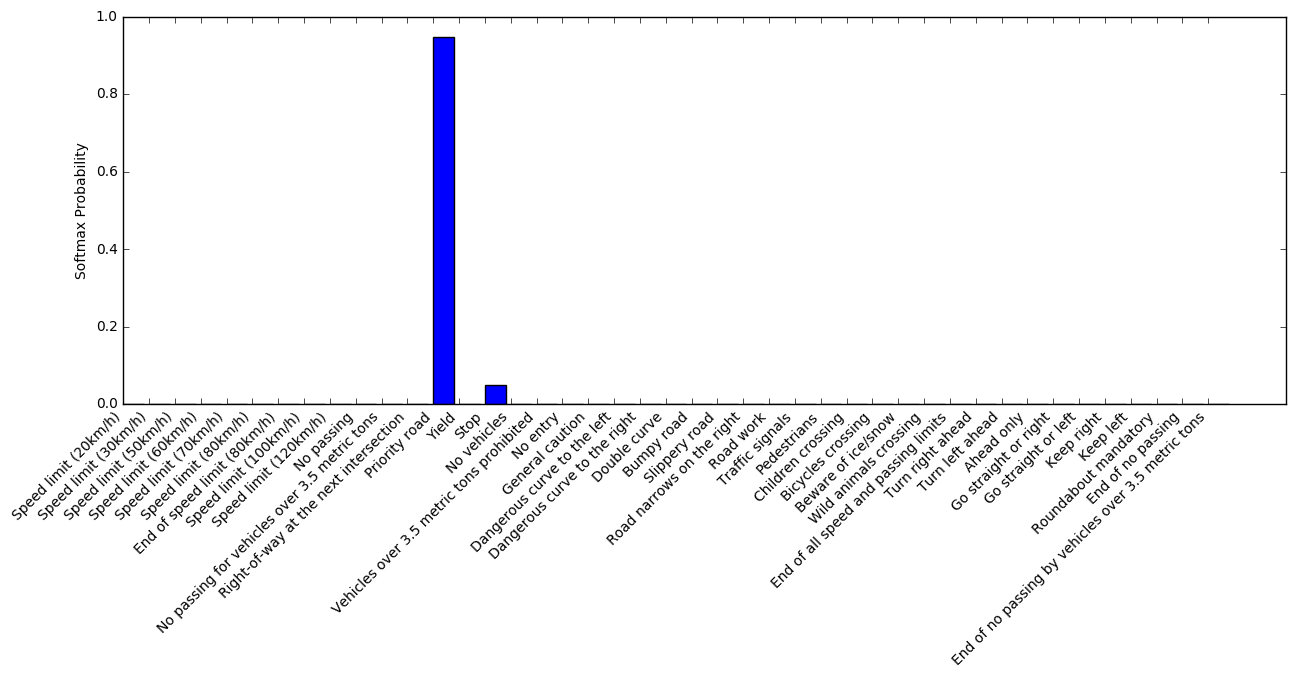

In [24]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top5_preds = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: testimgs})
    for i in range(len(imgfiles)):
        print(top5_preds.indices[i])
        print(top5_preds.values[i])
        vals = np.zeros((n_classes))
        vals[top5_preds.indices[i]] = top5_preds.values[i]
        
        plt.figure(figsize=(15, 5))
        plt.bar(np.arange(43), vals)
        plt.ylabel('Softmax Probability')
        plt.xticks(np.arange(0.0, 43.0, 1.0), SignNames, ha = 'right', rotation = 45)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.